Import pakages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob,pandas,time,os

import torch,torchvision
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchsummary import summary
from torcheval.metrics.functional import r2_score,mean_squared_error

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.backends.cudnn.version())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device.type)

2.0.0+cu117
True
11.7
8500
cuda


Some Utilities

Dataset

In [3]:
class MyDataSet(Dataset):
    def __init__(self,file_paths,labels_lists,transform):
        super().__init__()
        self.file_paths = file_paths
        self.labels_lists = labels_lists
        self.transform = transform
    def __len__(self):
        return len(self.file_paths)
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        image = Image.open(self.file_paths[index])
        image = self.transform(image).float()
        labels = self.labels_lists[index]
        labels = np.array(labels)
        labels = labels.astype('float').reshape(-1,4)
        sample = {'image':image,'psi':labels}
        return sample

DataLoader

In [4]:
def BuildKFoldDataLoader(images_fp,labels_fp,config,RGB_mean=(0.4961,0.4868,0.4890),RGB_std=(0.1098,0.1107,0.1084),K=5):
    #Read Images' path into numpy array
    img_pl = glob.glob(images_fp)
    img_pl = np.array(img_pl)
    
    #Read Labels numeric values into numpy array
    df = pandas.read_csv(labels_fp)
    df = df.iloc[:,20:24]
    psi = df.to_numpy()

    #shuffle original dataset
    orig_dataset = np.c_[img_pl,psi]
    np.random.seed(config['random_seed'])
    np.random.shuffle(orig_dataset)

    #Split data set into train and test
    train_inputs,train_K_inputs, test_inputs = [],[],[]
    train_labels,train_K_labels, test_labels = [],[],[]
    split_ratio = 0.8
    for data in orig_dataset[:int(len(orig_dataset)*split_ratio)]:
        train_inputs.append(data[0])
        train_labels.append([data[1:]])
    for data in orig_dataset[int(len(orig_dataset)*split_ratio):]:
        test_inputs.append(data[0])
        test_labels.append([data[1:]])
    for i in range(K):
        if i==K-1:
            train_K_inputs.append(train_inputs[i*len(train_inputs)//5:])
            train_K_labels.append(train_labels[i*len(train_labels)//5:])
        else:
            train_K_inputs.append(train_inputs[i*len(train_inputs)//5:(i+1)*len(train_inputs)//5])
            train_K_labels.append(train_labels[i*len(train_labels)//5:(i+1)*len(train_labels)//5])
    
    #Transform
    input_size = config['input_size'][1]
    normalize = torchvision.transforms.Normalize(mean = RGB_mean.tolist(), std = RGB_std.tolist())
    data_transforms = {
        'train': torchvision.transforms.Compose([
            torchvision.transforms.Resize(input_size),
            # torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            normalize
        ]),
        'test': torchvision.transforms.Compose([
            torchvision.transforms.Resize(input_size),
            # torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            normalize
        ])
    }

    #BuildDataLoader
    train_dataLoader = []
    for inputs,labels in zip(train_K_inputs,train_K_labels):
        train_dataLoader.append(DataLoader(MyDataSet(inputs,labels,data_transforms['train']),batch_size=config['batch_size'],shuffle=True))
    test_dataLoader = DataLoader(MyDataSet(test_inputs,test_labels,data_transforms['test']),batch_size=1,shuffle=False)
    
    return train_dataLoader,test_dataLoader
    

In [4]:
def BuildDataLoader(images_fp,labels_fp,config,RGB_mean=torch.tensor([0.4961,0.4868,0.4890]),RGB_std=torch.tensor([0.4961,0.4868,0.4890])):
    df = pandas.read_csv(labels_fp)
    df = df.iloc[:,20:24]
    psi = df.to_numpy()
    img_pl = glob.glob(images_fp)
    img_pl = np.array(img_pl)

    #shuffle
    orig_dataset = np.c_[img_pl,psi]
    np.random.seed(config['random_seed'])
    np.random.shuffle(orig_dataset)

    #split into train and test
    train_inputs, validation_inputs, test_inputs = [],[],[]
    train_labels, validation_labels, test_labels = [],[],[]
    train_num = int(len(orig_dataset)*0.6)
    val_num = int(len(orig_dataset)*0.8)
    for data in orig_dataset[:train_num]:
        train_inputs.append(data[0])
        train_labels.append([data[1:]])
    for data in orig_dataset[train_num:val_num]:
        validation_inputs.append(data[0])
        validation_labels.append([data[1:]])
    for data in orig_dataset[val_num:]:
        test_inputs.append(data[0])
        test_labels.append([data[1:]])

    input_size = config['input_size'][1]
    # normalize = torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    normalize = torchvision.transforms.Normalize(mean = RGB_mean.tolist(), std = RGB_std.tolist())
    data_transforms = {
        'train': torchvision.transforms.Compose([
            torchvision.transforms.Resize(input_size),
            # torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            normalize
        ]),
        'val': torchvision.transforms.Compose([
            torchvision.transforms.Resize(input_size),
            # torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            normalize
        ]),
        'test': torchvision.transforms.Compose([
            torchvision.transforms.Resize(input_size),
            # torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            normalize
        ])
    }

    train_dataLoader = DataLoader(MyDataSet(train_inputs,train_labels,data_transforms['train']),batch_size=config['batch_size'],shuffle=True)
    validation_dataLoader = DataLoader(MyDataSet(train_inputs,train_labels,data_transforms['val']),batch_size=config['batch_size'],shuffle=True)
    test_dataLoader = DataLoader(MyDataSet(test_inputs,test_labels,data_transforms['test']),batch_size=1,shuffle=False)
    
    return train_dataLoader,validation_dataLoader,test_dataLoader


In [5]:
def params_to_update(model:nn.Module)->list:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            # print("\t",name)
    return params_to_update

Train Validation Test

In [6]:
#Validation
def validation(validation_dataLoader:DataLoader,model:torch.nn.Module,criterion,device:torch.device):
    model.eval()
    loss = []
    for _, sample in enumerate(validation_dataLoader) :
        x, y = sample['image'].to(device), sample['psi'].to(device).float().squeeze(dim=1)
        with torch.no_grad():
            predict = model(x)
            loss.append(criterion(predict,y).detach().cpu().item())
    return loss


K-fold cross validation

In [7]:
#Train
def train_with_K_fold(train_dataLoader:list[DataLoader],model:torch.nn.Module,config,device:torch.device,checkpoint=None,K=5):
    start_epoch = 0
    max_epochs = config['max_epochs']
    min_loss = 1000.
    params_to_update_list = params_to_update(model)
    optimizer = getattr(torch.optim,config['optimizer'])(params_to_update_list,**config['optim_hparas'])   # Setup optimizer
    criterion = getattr(torch.nn,config['lossFunc'])(**config['loss_hparas'])                           # Setup criterion
    
    if checkpoint is not None:
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizers_state_dict'])
        min_loss = checkpoint['loss']
        start_epoch = checkpoint['epoch']
        
    loss_record = {'train':[],'validation':[]}
    early_stop_cnt = 0
    for epoch in range(start_epoch,max_epochs):
        start_time = time.time()
        validation_loss = []
        for i in range(K):
            model.train()                       # set model to training mode
            for j in range(K):
                if j==i:continue
                for _, sample in enumerate(train_dataLoader[j]) :
                    x, y = sample['image'].to(device), sample['psi'].to(device).float().squeeze(dim=1)
                    optimizer.zero_grad()           # set gradient to zero
                    x,y =x.to(device),y.to(device)  # move data to device (cpu/cuda)
                    predict = model(x)              # forward pass (compute output)
                    loss = criterion(predict,y)     # forward pass (compute output)
                    loss.backward()                 # compute gradient (backpropagation)
                    optimizer.step()                # update model with optimizer
                    loss_record['train'].append(loss.detach().cpu().item())

            # After each epoch, test your model on the validation (development) set.
            validation_loss.append(np.array(validation(train_dataLoader[i],model,criterion,device)).flatten())
        epoch+=1
        loss_record['validation'].extend(validation_loss)
        mean_loss = np.mean(validation_loss)
        if mean_loss < min_loss:
            #save model
            min_loss = mean_loss
            end_time = time.time()
            print('Saving model (epoch = {:4d}, loss = {:.4f} Cost {:.3f}(secs))'.format(epoch,mean_loss,(end_time - start_time)))
            torch.save({'model_state_dict':model.state_dict(),'optimizers_state_dict': optimizer.state_dict(),'loss':min_loss,'epoch':epoch},config['save_path'])
            early_stop_cnt = 0
        else:
            early_stop_cnt+=1
            if early_stop_cnt > config['early_stop']:
                break
    print('Finished training after {} epochs'.format(epoch))
    return min_loss,loss_record

In [7]:
#Train
def train(train_dataLoader:DataLoader,validation_dataLoader:DataLoader,model:torch.nn.Module,config,device:torch.device,checkpoint=None):
    start_epoch = 0
    max_epochs = config['max_epochs']
    min_loss = 1000.
    params_to_update_list = params_to_update(model)
    optimizer = getattr(torch.optim,config['optimizer'])(params_to_update_list,**config['optim_hparas'])   # Setup optimizer
    criterion = getattr(torch.nn,config['lossFunc'])(**config['loss_hparas'])                           # Setup criterion
    
    if checkpoint is not None:
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizers_state_dict'])
        min_loss = checkpoint['loss']
        start_epoch = checkpoint['epoch']
        
    loss_record = {'train':[],'validation':[]}
    early_stop_cnt = 0
    for epoch in range(start_epoch,max_epochs):
        start_time = time.time()        
        model.train()                       # set model to training mode
        for _, sample in enumerate(train_dataLoader) :
            x, y = sample['image'].to(device), sample['psi'].to(device).float().squeeze(dim=1)
            optimizer.zero_grad()           # set gradient to zero
            x,y =x.to(device),y.to(device)  # move data to device (cpu/cuda)
            predict = model(x)              # forward pass (compute output)
            loss = criterion(predict,y)     # forward pass (compute output)
            loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                # update model with optimizer
            loss_record['train'].append(loss.detach().cpu().item())
            # loss_record['train'].append(loss.item())

        # After each epoch, test your model on the validation (development) set.
        validation_loss = validation(validation_dataLoader,model,criterion,device)
        epoch+=1
        loss_record['validation'].extend(validation_loss)
        mean_loss = np.mean(validation_loss)
        if mean_loss < min_loss:
            #save model
            min_loss = mean_loss
            end_time = time.time()
            print('Saving model (epoch = {:4d}, loss = {:.4f} Cost {:.3f}(secs))'.format(epoch,mean_loss,(end_time - start_time)))
            # torch.save(model.state_dict(),config['save_path'])
            torch.save({'model_state_dict':model.state_dict(),'optimizers_state_dict': optimizer.state_dict(),'loss':min_loss,'epoch':epoch},config['save_path'])
            early_stop_cnt = 0
        else:
            early_stop_cnt+=1
            if early_stop_cnt > config['early_stop']:
                break
    print('Finished training after {} epochs'.format(epoch))
    return min_loss,loss_record

In [8]:
#Test
def test(test_dataLoader:DataLoader,model:torch.nn.Module,device:torch.device):
    model.eval()
    predict = []
    target = []
    for _, sample in enumerate(test_dataLoader) :
        x, y = sample['image'].to(device), sample['psi'].to(device).float().squeeze(dim=1)
        with torch.no_grad():
            pred = model(x)
            predict.append(pred.detach().cpu())
            target.append(y.detach().cpu())
    predict = torch.cat(predict,dim=0)
    target = torch.cat(target,dim=0)
    
    R2 = r2_score(predict,target)
    MSE = mean_squared_error(predict,target)
    return R2,MSE,predict,target


In [9]:
def getMeanStd(train_fp):
    if not os.path.exists(train_fp):
        return torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])
    # train_fp = "../01DataPreProcessing/crop_img/"
    RGB_mean = torch.tensor([0,0,0],dtype=torch.float32)
    RGB_std = torch.tensor([0,0,0],dtype=torch.float32)
    transform = torchvision.transforms.ToTensor()
    n = 0
    for fp in glob.glob(train_fp+"*.jpg"):
        with Image.open(fp) as img:
            img = transform(img)
            RGB_mean += img.mean(dim=(1,2))
            RGB_std += img.std(dim=(1,2))
            n+=1
    RGB_mean /= n
    RGB_std /= n
    return RGB_mean,RGB_std

Plot

In [10]:
def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['validation'])]
    plt.figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['validation'], c='tab:cyan', label='validation')
    plt.ylim(0.0, 1.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()
def plot_pred(predict,target,lim=2.5):
    plt.figure(figsize=(5, 5))
    plt.scatter(target, predict, c='r', alpha=0.5)
    plt.plot([-1.5, lim], [-1.5, lim], c='b')
    plt.xlim(-1.5, lim)
    plt.ylim(-1.5, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

Model

In [11]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN,self).__init__()
        #3*488*488 -> 24*244*244
        #If Conv2d comes with BatchNorm, the bias should be set to False.
        self.layer0 = nn.Sequential(nn.Conv2d(3,6,kernel_size=(7,7),stride=(2,2),padding=(1,1), bias=False)
                                         ,nn.BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                                         ,nn.ReLU()
                                         ,nn.MaxPool2d(2,2))
        self.layer1 = nn.Sequential(nn.Conv2d(6,48,kernel_size=(5,5),stride=(2,2),padding=(1,1), bias=False)
                                         ,nn.BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                                         ,nn.ReLU()
                                         ,nn.MaxPool2d(2,2))
        self.layer2 = nn.Sequential(nn.Conv2d(48,128,kernel_size=(3,3),stride=(2,2),padding=(1,1), bias=False)
                                         ,nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                                         ,nn.ReLU()
                                         ,nn.MaxPool2d(4,4))
        self.flatten = nn.Flatten()
        # self.fc0 = torch.nn.Sequential(torch.nn.Linear(in_features=6272,out_features=784),torch.nn.LeakyReLU())
        # self.fc1 = torch.nn.Sequential(torch.nn.Linear(in_features=784,out_features=49),torch.nn.LeakyReLU())
        # self.fc2 = torch.nn.Sequential(torch.nn.Linear(in_features=49,out_features=4),torch.nn.LeakyReLU())
        self.fc0 = torch.nn.Sequential(torch.nn.Linear(in_features=1152,out_features=288),torch.nn.LeakyReLU())
        self.fc1 = torch.nn.Sequential(torch.nn.Linear(in_features=288,out_features=72),torch.nn.LeakyReLU())
        self.fc2 = torch.nn.Sequential(torch.nn.Linear(in_features=72,out_features=4),torch.nn.LeakyReLU())

    def forward(self,x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.flatten(x)
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
        

Main

Hyper-parameters

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.makedirs('./models/',exist_ok=True)
target_only = False

config ={
    'imput_filepath':'../01DataPreProcessing/aug_images_centerCrop/',
    'input_size':(3,488,488),
    'random_seed':9978,
    'max_epochs':2,
    'batch_size':1,
    # 'optimizer':'SGD',
    # 'optim_hparas':{
    #     'lr':0.001,
    #     'momentum':0.8
    # },
    'optimizer':'Adam',
    'optim_hparas':{
        'lr':1e-2,
        'betas':(0.9, 0.999),
        'eps':1e-8,
        'weight_decay':0
    },
    'lossFunc':'MSELoss',
    'loss_hparas':{},
    'early_stop':10,
    'load_path':'./models/CNN01.pt',
    'save_path':'./models/CNN01.pt'
}

In [13]:
myCnn = MyCNN()
myCnn = myCnn.to(device)
params = params_to_update(myCnn)
model = myCnn

In [13]:
summary(model,config['input_size'])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 242, 242]             882
       BatchNorm2d-2          [-1, 6, 242, 242]              12
              ReLU-3          [-1, 6, 242, 242]               0
         MaxPool2d-4          [-1, 6, 121, 121]               0
            Conv2d-5           [-1, 48, 60, 60]           7,200
       BatchNorm2d-6           [-1, 48, 60, 60]              96
              ReLU-7           [-1, 48, 60, 60]               0
         MaxPool2d-8           [-1, 48, 30, 30]               0
            Conv2d-9          [-1, 128, 15, 15]          55,296
      BatchNorm2d-10          [-1, 128, 15, 15]             256
             ReLU-11          [-1, 128, 15, 15]               0
        MaxPool2d-12            [-1, 128, 3, 3]               0
          Flatten-13                 [-1, 1152]               0
           Linear-14                  [

Get Mean&STD for normalization

In [14]:
# RGB_mean,RGB_std = getMeanStd(config['imput_filepath'])
RGB_mean,RGB_std = torch.tensor([0.4961,0.4868,0.4890]),torch.tensor([0.1098,0.1107,0.1084])

Training with holdout set

In [16]:
train_dataLoader,validation_dataLoader,test_dataLoader = BuildDataLoader("../01DataPreProcessing/aug_images_centerCrop/*.jpg","../01DataPreProcessing/ftt_psi_10.csv",config,RGB_mean,RGB_std)

In [ ]:
checkpoint = torch.load(config['load_path'])

In [ ]:
# min_loss,loss_record = train(train_dataLoader,validation_dataLoader,model,config,device)
min_loss,loss_record = train(train_dataLoader,validation_dataLoader,model,config,device,checkpoint) #with checkpoint

Training with K-Fold cross validation

In [15]:
train_dataLoader,test_dataLoader = BuildKFoldDataLoader("../01DataPreProcessing/aug_images_centerCrop/*.jpg","../01DataPreProcessing/ftt_psi_10.csv",config,RGB_mean,RGB_std,5)

In [ ]:
checkpoint = torch.load(config['load_path'])

In [16]:
checkpoint=None

In [22]:
min_loss,loss_record = train_with_K_fold(train_dataLoader,model,config,device,checkpoint,5) #with checkpoint

In [21]:
vl = loss_record['validation']

Plot and Test

In [ ]:
plot_learning_curve(loss_record, title='CNN02')

In [23]:
checkpoint = torch.load(config['save_path'])
model = MyCNN()
model.load_state_dict(checkpoint['model_state_dict'])
R2score,mse,predict,target = test(test_dataLoader,model,device)

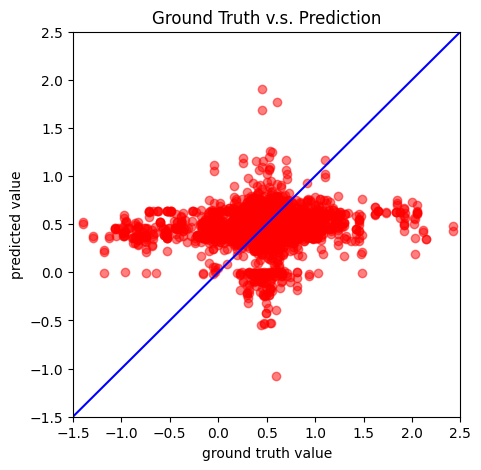

R2 Score : -0.15048
MSE : 0.16599


In [24]:
plot_pred(predict,target)
print('R2 Score : %.5f'%R2score.item()) # -infinite ~ 1
print('MSE : %.5f'%mse.item())